# exp058
相対位置が絶対位置より精度がよいphoneの確認

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [4]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [7]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [8]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [9]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [10]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

# データ取得

In [11]:
train = pd.read_csv('../output/exp045/train_ro_rog_kf_sp0_pm_ps.csv')
gt = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
degree = pd.read_csv('../output/prep/degree_pred_v002/train_degree_pred.csv')
dist = pd.read_csv('../output/prep/distance_pred_v002/train_distance_pred.csv')
sp0 = pd.read_csv('../output/prep/speed0_pred_v001/train_sp0_pred.csv')
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [12]:
dist = dist.rename(columns={'pred': 'dist_pred'}) 

In [13]:
train = train.merge(degree[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(dist[['phone', 'millisSinceGpsEpoch', 'dist_pred']], on=['phone', 'millisSinceGpsEpoch'], how='left')
train = train.merge(sp0[['phone', 'millisSinceGpsEpoch', 'isSpeed0']], on=['phone', 'millisSinceGpsEpoch'], how='left')

In [14]:
train.loc[train['isSpeed0'], 'dist_pred'] = 0

In [15]:
train

collectionName        phoneName  millisSinceGpsEpoch     latDeg  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442  37.423582   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442  37.423582   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442  37.423582   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442  37.423582   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442  37.423583   
...                     ...              ...                  ...        ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000  37.334472   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000  37.334472   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000  37.334472   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000  37.334472   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000  37.334472   

            lngDeg                                phone  \
0      -122.094127           2020-05-14-US-MTV-1_Pixel4   
1      -122.094127           2020-05-14-US-MTV-1_Pixel4   
2      -122.094127           2020-05-14-US-MTV-1_Pixel4   
3      -122.094127           2020-05-14-US-MTV-1_Pixel4   
4      -122.094127           2020-05-14-US-MTV-1_Pixel4   
...            ...                                  ...   
131337 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131338 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131339 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131340 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   
131341 -121.899604  2021-04-29-US-SJC-2_SamsungS20Ultra   

        heightAboveWgs84EllipsoidM             x             y             z  \
0                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
1                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
2                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
3                             63.5 -2.694608e+06 -4.296551e+06  3.854871e+06   
4                             63.5 -2.694608e+06 -4.296552e+06  3.854870e+06   
...                            ...           ...           ...           ...   
131337                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131338                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131339                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131340                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   
131341                        63.5 -2.683178e+06 -4.310772e+06  3.847012e+06   

        ...     ydiff            zp     zdiff      dist          xnew  \
0       ...       NaN           NaN       NaN       NaN           NaN   
1       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
2       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
3       ...  0.000000  3.854871e+06  0.000000  0.000000           NaN   
4       ... -0.191047  3.854871e+06 -0.380402  0.490277 -2.694608e+06   
...     ...       ...           ...       ...       ...           ...   
131337  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131338  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131339  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131340  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   
131341  ...  0.000000  3.847012e+06  0.000000  0.000000           NaN   

                ynew          znew   calc_deg  dist_pred  isSpeed0  
0                NaN           NaN   0.981589   0.000000         1  
1                NaN           NaN   0.787438   0.000000         1  
2                NaN           NaN   0.705617   0.588411         1  
3                NaN           NaN   0.645836  -0.154450         1  
4      -4.296551e+06  3.854871e+06   0.638460  -0.620824         1  
...              ...           ...        ...        ...       ...  
131337           NaN  

In [16]:
train_org = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')

train[['latDeg_org', 'lngDeg_org']] = train_org[['latDeg', 'lngDeg']]
train[['latDeg_gt', 'lngDeg_gt']] = gt[['latDeg', 'lngDeg']]

# 相対座標

In [17]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [18]:
def calc_next_coordinate(df):
    phones = df['phone'].unique()
    df['lat_next'] = np.nan
    df['lng_next'] = np.nan
    
    for idx in range(len(df)-1):
        if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
            continue
            
        lat = df.at[idx, 'latDeg_gt']
        lng = df.at[idx, 'lngDeg_gt']
        deg = df.at[idx, 'calc_deg']
        speed = df.at[idx, 'dist_pred']
        
        res = vincenty_direct(lat, lng, deg, speed)
        if res:
            df.at[idx+1, 'lat_next'] = res['lat']
            df.at[idx+1, 'lng_next'] = res['lon']
        
    return df

In [19]:
train = calc_next_coordinate(train)

In [20]:
train['lat_next'] = train.groupby('phone')['lat_next'].fillna(method='bfill')
train['lng_next'] = train.groupby('phone')['lng_next'].fillna(method='bfill')
train['lat_next'] = train.groupby('phone')['lat_next'].fillna(method='ffill')
train['lng_next'] = train.groupby('phone')['lng_next'].fillna(method='ffill')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


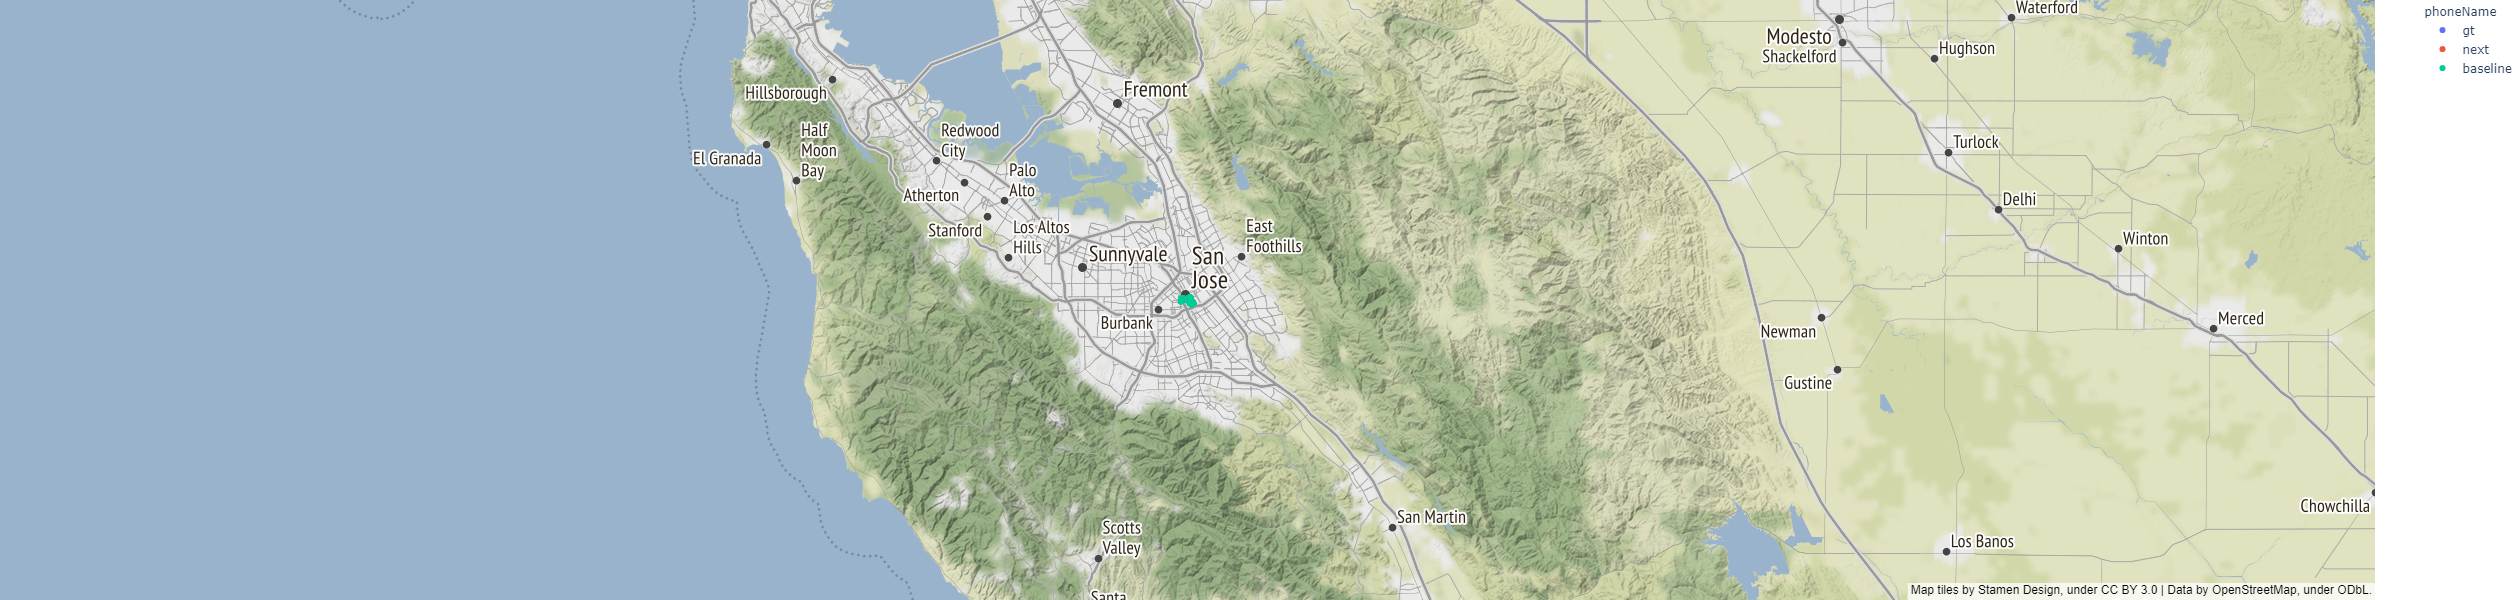

In [21]:
tmp0 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_org', 'lngDeg_org']]
tmp1 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt']].copy()
tmp2 = train[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'lat_next', 'lng_next']].copy()

tmp0.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
tmp1.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
tmp2.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']

tmp0['phoneName'] = 'baseline'
tmp1['phoneName'] = 'gt'
tmp2['phoneName'] = 'next'

tmp = pd.concat([tmp1, tmp2, tmp0])

visualize_collection(tmp, '2021-04-22-US-SJC-1')

In [22]:
phones = train['phone'].unique()

base_scores = []
abs_scores = []
rel_scores = []

for phone in phones:
    tmp = train[train['phone']==phone].copy()
    tmp_base = tmp[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_org', 'lngDeg_org']].copy()
    tmp_abs = tmp[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
    tmp_rel = tmp[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'lat_next', 'lng_next']].copy()
    
    tmp_base.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
    tmp_rel.columns = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
    
    res_base = train_result(tmp_base)
    res_abs = train_result(tmp_abs)
    res_rel = train_result(tmp_rel)
    
    base_scores.append(res_base.score)
    abs_scores.append(res_abs.score)
    rel_scores.append(res_rel.score)

In [23]:
result = pd.DataFrame()
result['phone'] = phones
result['baseline'] = base_scores
result['abs_pred'] = abs_scores
result['rel_pred'] = rel_scores

In [28]:
result

phone   baseline   abs_pred      rel_pred
0            2020-05-14-US-MTV-1_Pixel4   2.100602   1.745663      9.227972
1    2020-05-14-US-MTV-1_Pixel4XLModded   3.169948   1.621890     53.206727
2            2020-05-14-US-MTV-2_Pixel4   2.083836   2.386477      8.235942
3    2020-05-14-US-MTV-2_Pixel4XLModded   7.362609   3.191301     58.627986
4            2020-05-21-US-MTV-1_Pixel4   3.240721   2.459009      2.723242
5            2020-05-21-US-MTV-2_Pixel4   2.119429   1.449851      7.046100
6          2020-05-21-US-MTV-2_Pixel4XL   2.277322   1.374579      6.032700
7            2020-05-29-US-MTV-1_Pixel4   3.669069   2.772727      4.804604
8          2020-05-29-US-MTV-1_Pixel4XL   3.081682   2.466826      4.536150
9    2020-05-29-US-MTV-1_Pixel4XLModded   3.205411   2.444214     56.668396
10           2020-05-29-US-MTV-2_Pixel4   3.598939   2.851519      4.127700
11         2020-05-29-US-MTV-2_Pixel4XL   3.514311   2.829371      6.342739
12           2020-06-04-US-MTV-1_Pixel4   2.710530   1.905969      2.400453
13         2020-06-04-US-MTV-1_Pixel4XL   1.979366   1.489655      5.179970
14   2020-06-04-US-MTV-1_Pixel4XLModded   2.769973   2.169977     57.601418
15           2020-06-05-US-MTV-1_Pixel4   2.855825   1.781814      3.590715
16         2020-06-05-US-MTV-1_Pixel4XL   1.873319   1.851566      6.336010
17   2020-06-05-US-MTV-1_Pixel4XLModded   2.635756   1.576123     34.101289
18           2020-06-05-US-MTV-2_Pixel4   2.846215   1.729148     38.366855
19         2020-06-05-US-MTV-2_Pixel4XL   2.291061   1.659307     36.262528
20           2020-06-11-US-MTV-1_Pixel4   2.584156   1.433150      8.104044
21         2020-06-11-US-MTV-1_Pixel4XL   1.862374   1.496500      4.369869
22           2020-07-08-US-MTV-1_Pixel4   2.973690   1.960521      3.866290
23         2020-07-08-US-MTV-1_Pixel4XL   2.027415   1.731945      3.515584
24   2020-07-08-US-MTV-1_Pixel4XLModded   2.226050   1.667882      6.867486
25              2020-07-17-US-MTV-1_Mi8   3.111716   2.580386  27297.848346
26              2020-07-17-US-MTV-2_Mi8   3.845886   3.555662  15228.315306
27              2020-08-03-US-MTV-1_Mi8   3.629468   2.223023           NaN
28           2020-08-03-US-MTV-1_Pixel4   2.882963   2.372959           NaN
29              2020-08-06-US-MTV-2_Mi8   2.605095   2.318921           NaN
30           2020-08-06-US-MTV-2_Pixel4   2.276232   1.614158           NaN
31         2020-08-06-US-MTV-2_Pixel4XL   2.083141   1.879999           NaN
32               2020-09-04-US-SF-1_Mi8   3.547295   2.814507  23757.397279
33            2020-09-04-US-SF-1_Pixel4   7.249871   6.378533      6.258117
34          2020-09-04-US-SF-1_Pixel4XL   2.475411   1.898588      6.155085
35               2020-09-04-US-SF-2_Mi8   3.707254   3.159337  23920.668102
36            2020-09-04-US-SF-2_Pixel4   3.183916   2.355003      9.355400
37          2020-09-04-US-SF-2_Pixel4XL   2.608431   2.378459      6.577635
38           2021-01-04-US-RWC-1_Pixel4   2.436517   1.824563      6.711724
39     2021-01-04-US-RWC-1_Pixel4Modded   4.827466   2.797859      7.171221
40         2021-01-04-US-RWC-1_Pixel4XL   5.980190   3.552696      7.673710
41           2021-01-04-US-RWC-1_Pixel5   2.347644   1.963574      6.399720
42           2021-01-04-US-RWC-2_Pixel4   2.866028   2.368199      7.124031
43     2021-01-04-US-RWC-2_Pixel4Modded   5.548016   3.257059     12.046264
44         2021-01-04-US-RWC-2_Pixel4XL   6.439227   4.268014      8.002440
45           2021-01-04-US-RWC-2_Pixel5   2.971098   2.645891      5.828307
46              2021-01-05-US-SVL-1_Mi8   2.968176   2.206702   1451.945679
47           2021-01-05-US-SVL-1_Pixel4   2.768900   2.414122      5.326115
48         2021-01-05-US-SVL-1_Pixel4XL   7.921799   4.153333      5.427015
49           2021-01-05-US-SVL-1_Pixel5   9.826826   4.965081      5.691502
50           2021-01-05-US-SVL-2_Pixel4   2.510146   1.990668      6.470082
51     2021-01-05-US-SVL-2_Pixel4Modded   2.406581   2.035487      7.622792
52    

In [26]:
# baselineより相対予測の方が精度が良いphone
a = result[result['baseline']>result['rel_pred']]
display(a)
print(a['phone'].values)

phone   baseline   abs_pred  rel_pred
4            2020-05-21-US-MTV-1_Pixel4   3.240721   2.459009  2.723242
12           2020-06-04-US-MTV-1_Pixel4   2.710530   1.905969  2.400453
33            2020-09-04-US-SF-1_Pixel4   7.249871   6.378533  6.258117
48         2021-01-05-US-SVL-1_Pixel4XL   7.921799   4.153333  5.427015
49           2021-01-05-US-SVL-1_Pixel5   9.826826   4.965081  5.691502
52         2021-01-05-US-SVL-2_Pixel4XL   6.913886   2.027321  6.347324
53         2021-03-10-US-SVL-1_Pixel4XL   7.093320   3.999552  2.945218
54  2021-03-10-US-SVL-1_SamsungS20Ultra   6.259629   3.960118  2.483604
55           2021-04-15-US-MTV-1_Pixel4   4.864709   2.474155  4.013634
58  2021-04-15-US-MTV-1_SamsungS20Ultra   7.384374   5.908682  4.006906
59           2021-04-22-US-SJC-1_Pixel4  24.659978  10.941343  2.567469
60  2021-04-22-US-SJC-1_SamsungS20Ultra  17.768176  10.741640  2.622990
62           2021-04-26-US-SVL-1_Pixel5   3.500739   2.239183  2.711800
63           2021-04-28-US-MTV-1_Pixel4   4.774786   2.675407  1.968472
65  2021-04-28-US-MTV-1_SamsungS20Ultra   7.247875   3.219529  1.707112
66           2021-04-28-US-SJC-1_Pixel4  14.370940   9.585585  3.396771
67  2021-04-28-US-SJC-1_SamsungS20Ultra  20.170898   9.810351  2.743454
68           2021-04-29-US-MTV-1_Pixel4  11.033945   5.537791  2.670685
69           2021-04-29-US-MTV-1_Pixel5  11.093281   5.331694  2.753557
70  2021-04-29-US-MTV-1_SamsungS20Ultra  10.041490   6.249071  1.795663
71           2021-04-29-US-SJC-2_Pixel4  20.182596   9.456015  2.778047
72  2021-04-29-US-SJC-2_SamsungS20Ultra  19.444815   9.465236  2.177442

['2020-05-21-US-MTV-1_Pixel4' '2020-06-04-US-MTV-1_Pixel4'
 '2020-09-04-US-SF-1_Pixel4' '2021-01-05-US-SVL-1_Pixel4XL'
 '2021-01-05-US-SVL-1_Pixel5' '2021-01-05-US-SVL-2_Pixel4XL'
 '2021-03-10-US-SVL-1_Pixel4XL' '2021-03-10-US-SVL-1_SamsungS20Ultra'
 '2021-04-15-US-MTV-1_Pixel4' '2021-04-15-US-MTV-1_SamsungS20Ultra'
 '2021-04-22-US-SJC-1_Pixel4' '2021-04-22-US-SJC-1_SamsungS20Ultra'
 '2021-04-26-US-SVL-1_Pixel5' '2021-04-28-US-MTV-1_Pixel4'
 '2021-04-28-US-MTV-1_SamsungS20Ultra' '2021-04-28-US-SJC-1_Pixel4'
 '2021-04-28-US-SJC-1_SamsungS20Ultra' '2021-04-29-US-MTV-1_Pixel4'
 '2021-04-29-US-MTV-1_Pixel5' '2021-04-29-US-MTV-1_SamsungS20Ultra'
 '2021-04-29-US-SJC-2_Pixel4' '2021-04-29-US-SJC-2_SamsungS20Ultra']


In [27]:
# 絶対予測より相対予測の方が精度が良いphone
a = result[result['abs_pred']>result['rel_pred']]
display(a)
print(a['phone'].values)

phone   baseline   abs_pred  rel_pred
33            2020-09-04-US-SF-1_Pixel4   7.249871   6.378533  6.258117
53         2021-03-10-US-SVL-1_Pixel4XL   7.093320   3.999552  2.945218
54  2021-03-10-US-SVL-1_SamsungS20Ultra   6.259629   3.960118  2.483604
58  2021-04-15-US-MTV-1_SamsungS20Ultra   7.384374   5.908682  4.006906
59           2021-04-22-US-SJC-1_Pixel4  24.659978  10.941343  2.567469
60  2021-04-22-US-SJC-1_SamsungS20Ultra  17.768176  10.741640  2.622990
63           2021-04-28-US-MTV-1_Pixel4   4.774786   2.675407  1.968472
65  2021-04-28-US-MTV-1_SamsungS20Ultra   7.247875   3.219529  1.707112
66           2021-04-28-US-SJC-1_Pixel4  14.370940   9.585585  3.396771
67  2021-04-28-US-SJC-1_SamsungS20Ultra  20.170898   9.810351  2.743454
68           2021-04-29-US-MTV-1_Pixel4  11.033945   5.537791  2.670685
69           2021-04-29-US-MTV-1_Pixel5  11.093281   5.331694  2.753557
70  2021-04-29-US-MTV-1_SamsungS20Ultra  10.041490   6.249071  1.795663
71           2021-04-29-US-SJC-2_Pixel4  20.182596   9.456015  2.778047
72  2021-04-29-US-SJC-2_SamsungS20Ultra  19.444815   9.465236  2.177442

['2020-09-04-US-SF-1_Pixel4' '2021-03-10-US-SVL-1_Pixel4XL'
 '2021-03-10-US-SVL-1_SamsungS20Ultra'
 '2021-04-15-US-MTV-1_SamsungS20Ultra' '2021-04-22-US-SJC-1_Pixel4'
 '2021-04-22-US-SJC-1_SamsungS20Ultra' '2021-04-28-US-MTV-1_Pixel4'
 '2021-04-28-US-MTV-1_SamsungS20Ultra' '2021-04-28-US-SJC-1_Pixel4'
 '2021-04-28-US-SJC-1_SamsungS20Ultra' '2021-04-29-US-MTV-1_Pixel4'
 '2021-04-29-US-MTV-1_Pixel5' '2021-04-29-US-MTV-1_SamsungS20Ultra'
 '2021-04-29-US-SJC-2_Pixel4' '2021-04-29-US-SJC-2_SamsungS20Ultra']
